<a href="https://colab.research.google.com/github/zhaosmas/BA-780-Team5-Project/blob/main/B5_Predict_the_Popularity_of_Online_News.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict the Popularity of Online News: What Really Drives People to Click?**
Team 5: Tzu-Ching (Charlie) Chou, Yutao (Peter) Luo, Lingxuan (Alice) Wang, Fanfei Zhao, Sheng (Johnny) Zhou


## **Table of Contents**
Part 1: Introduction & Motivation

Part 2: Project Proposal

Part 3: Report Summary

Part 4: Data Source Overview

Part 5: Data Cleaning & Preprocessing

Part 6: Data Analysis

Part 7: Classification Prediction Model

Part 8: Conclusion

Part 9: References 


## **Part 1: Introduction & Motivation**
Online news media has flourished in this decade and is gradually replacing traditional newspapers. Understanding what kind of articles will draw audiences’ attention has been the focus of online news outlets. These media companies have been relying on social media analytics to increase website traffic and gain more readers. Through our analysis, we aim to understand what drives people to click on articles and further provide insights which can benefit authors, online news media, advertising companies, etc.

## **Part 2: Project Proposal**
Our goal is to predict the popularity of online news published by Masheable. We will use Python on a challenging dataset to compute various visualizations to identify what characteristics of online news will lead to a higher number of shares in the social networks. We will also build a machine learning model to predict whether an article is popular or not and display which features are most important for a popular article.

## **Part 3: Report Summary**
Our team explored articles published on Marshable and identified key variables which will lead to higher popularity of articles. There are 1) number of images, 2) number of videos, 3) number of links, 4) number of keywords, 5) number of positive and negative words, 6) weekend, 7) channels. In addition, we developed a classification prediction model to predict an article’s popularity. The model has 68% ROC accuracy.

## **Part 4: Data Source Overview**
The dataset is from UCI Machine Learning Repository (source link: [Online News Popularity Data Set](https://archive.ics.uci.edu/ml/datasets/Online+News+Popularity)). It summarizes a heterogeneous set of features about articles published by Mashable over two years. There are 61 columns and 39,644 rows in the dataset. The variables’ description is available through this link: [variable dictionary](https://docs.google.com/document/d/1i2WD6uWaSdCU8ID4Zl3I6bFcBz6FmHISN_OLixUUjco/edit?usp=sharing). 

The dataset’s columns could be summarized into three categories: content characteristics, publish characteristics, and popularity. Content characteristics (`num_imgs`, `num_videos`, `title_subjectivity`, etc.) includes an article’s basic information such as the number of images and videos included. Publish characteristics (`data_channel_is_lifestyle`, `is_weekend`, etc.) includes information about the article’s publication details, such as which channel the article belongs to and on what day the article is published. Popularity (`shares`) is our target variable which is the number of shares of one article. It evaluates an article’s popularity. To clarify, `shares` is different from `self_reference_min_shares`, `self_reference_max_shares`, and `self_reference_avg_shares`. The latter three measure the minimum, maximum, and average shares of referenced articles in each Mashable article. To be more explicit, in one particular article, the author refers to three articles published in Mashable. These variables measure the number of shares of these three referenced articles. Due to limited descriptions of the original variables, we cannot be sure how some variables are computed.  

There are three data types in this dataset which are object, float, and integer. Except `url` which is an object, all other variables are numeric values. However, there are categorical variables which have been converted to dummy variables, i.e. `data_channel_is ` and `weekday_is_`.  

Last but not least, all the variables have the same number of records which implies that there is no missing value in this dataset.

In [ ]:
# import packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# import dataset
from google.colab import drive
drive.mount('/content/drive')
data_folder = '/content/drive/Shareddrives/BA780/'
df = pd.read_csv(data_folder+'OnlineNewsPopularity.csv')

# return the basic information of the dataset
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos              

## **Part 5: Data Cleaning & Preprocessing**

### 1. Format Variables’ Names
We found that every variable’s name starts with an unexpected space, so we ran the following code to remove the space.

In [ ]:
df.columns = df.columns.str.strip()

### 2. Extract Date from `url`
This dataset contains articles published by Mashable from the time period of 2013-01-07 to 2014-12-27.

In [ ]:
# extract date
df['date']=[i[3:6] for i in df['url'].str.split('/')]
df['date']=['/'.join(i) for i in df['date']]
df['date']=pd.to_datetime(df['date'])
df['published_year'] = pd.DatetimeIndex(df['date']).year
df['published_month']= pd.DatetimeIndex(df['date']).month

# return the earliest and latest dates in the dataset
print('earliest date: ', df.date.min())
print('latest date: ', df.date.max())

earliest date:  2013-01-07 00:00:00
latest date:  2014-12-27 00:00:00


### 3. Drop Variables and Assign a New Name for the Updated Dataset
When we reviewed our dataset and the variable dictionary, we discovered that there are many variables with obscure explanations. Since these variables are described unclearly, we might misunderstand and misuse them. Therefore, we decided to drop these variables, including `n_non_stop_words`,  `kw_min_min`,  `LDA_00`, `rate_positive_words`, `min_positive_polarity`, `abs_title_subjectivity` . Besides, we decided to remove the variables which may not have predictive power on our target variable `shares`, such as `timedelta` which stands for the days between the article publication and the dataset acquisition. After we dropped these variables, there are 36 columns in total. We assigned a new name called `news` for the updated dataset.

In [ ]:
# drop variables
news = df.drop(['url', 'timedelta', 'n_unique_tokens', 'n_non_stop_words', 
                'n_non_stop_unique_tokens', 'average_token_length', 
                'kw_min_min', 'kw_max_min', 'kw_avg_min','kw_min_max', 
                'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg', 
                'kw_avg_avg', 'LDA_00', 'LDA_01','LDA_02', 'LDA_03', 'LDA_04', 
                'rate_positive_words', 'rate_negative_words', 
                'min_positive_polarity', 'max_positive_polarity', 
                'min_negative_polarity', 'max_negative_polarity', 
                'abs_title_subjectivity', 'abs_title_sentiment_polarity'], axis=1)

# dataset preview
news.head(3)

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
0            12.0             219.0        4.0             2.0       1.0   
1             9.0             255.0        3.0             1.0       1.0   
2             9.0             211.0        3.0             1.0       1.0   

   num_videos  num_keywords  data_channel_is_lifestyle  \
0         0.0           5.0                        0.0   
1         0.0           4.0                        0.0   
2         0.0           6.0                        0.0   

   data_channel_is_entertainment  data_channel_is_bus  ...  \
0                            1.0                  0.0  ...   
1                            0.0                  1.0  ...   
2                            0.0                  1.0  ...   

   global_rate_positive_words  global_rate_negative_words  \
0                    0.045662                    0.013699   
1                    0.043137                    0.015686   
2                    0.056872                    0.009479   

   avg_positive_polarity  avg_negative_polarity  title_subjectivity  \
0               0.378636              -0.350000                 0.5   
1               0.286915              -0.118750                 0.0   
2               0.495833              -0.466667                 0.0   

   title_sentiment_polarity  shares       date  published_year  \
0                   -0.1875     593 2013-01-07            2013   
1                    0.0000     711 2013-01-07            2013   
2                    0.0000    1500 2013-01-07            2013   

   published_month  
0                1  
1                1  
2                1  

[3 rows x 36 columns]

## **Part 6: Data Analysis**

### 1. Correlation Matrix
After we cleaned our dataset, we ran the following code to compute a correlation matrix. We first dropped categorical variables which are not insightful for correlation and computed a numeric data frame called `news_numeric`. We will only use this numeric data frame for computing the correlation matrix and will still use categorical variables to generate visualizations and perform analysis later in the notebook. The correlation matrix indicates several strong associations. For example, there is a strong positive correlation between the number of links and the number of words which means that the increase of links will increase the number of words. In addition, more significant correlations are generated related to the subjectivity, positive or negative words, and average polarity of positive or negative words. For example, as the average polarity of negative words increases, title subjectivity decreases.

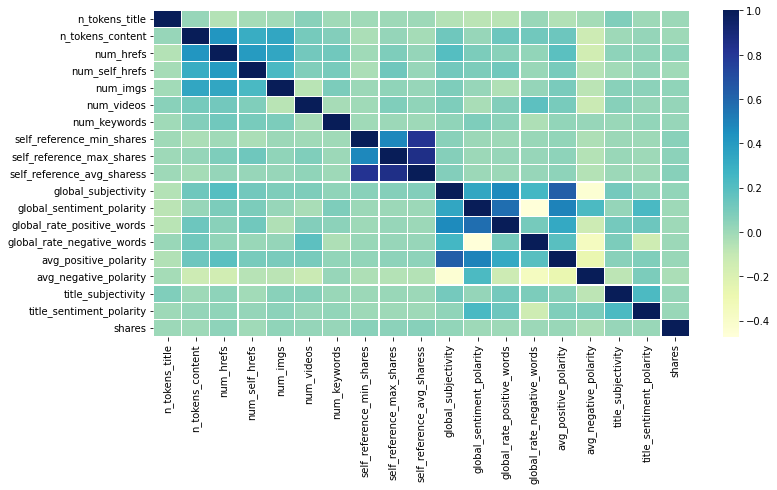

In [ ]:
# drop categorical variables
news_numeric = news.drop(['data_channel_is_lifestyle', 
                           'data_channel_is_entertainment', 
                           'data_channel_is_bus', 'data_channel_is_socmed', 
                           'data_channel_is_tech', 'data_channel_is_world',
                           'weekday_is_monday', 'weekday_is_tuesday',
                           'weekday_is_wednesday', 'weekday_is_thursday', 
                           'weekday_is_friday', 'weekday_is_saturday', 
                           'weekday_is_sunday', 'is_weekend','date',
                          'published_year','published_month'], axis=1)

# return correlation matrix
plt.figure(figsize=(12, 6))
corr = news_numeric.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

### 2. Distribution of Number of Shares
By computing the mean and median, we found that the mean of shares is greater than the median of shares in our dataset. Then, we ran the following codes to see the distribution of shares. Based on the graph, it is a right-skewed distribution which means that the mean is greater than the median. In addition, we plotted two vertical lines to visualize the difference. One line indicates the median which shows in red and the other one indicates the mean which shows in blue. The mean overestimates the most common values in a positively skewed distribution. In other words, we will overestimate the number of shares if we use the mean to divide the shares. 

In [ ]:
# return the mean and median of shares
print('mean of shares: ' , round(news.shares.mean(),2))
print('median of shares: ', round(news.shares.median(),2))

mean of shares:  3395.38
median of shares:  1400.0


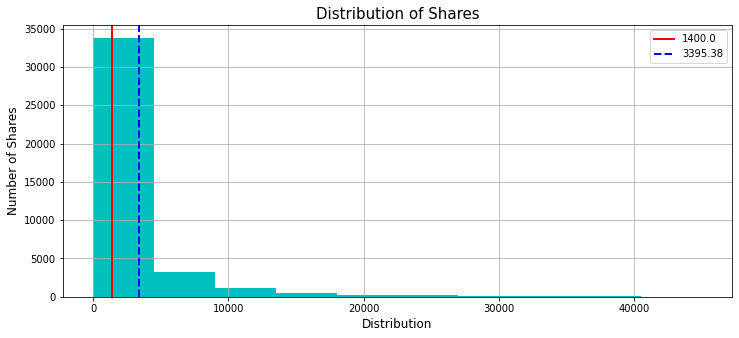

In [ ]:
# return the histogram
news.hist(column='shares', range=[0, 45000], color = 'c',figsize = (12,5))
plt.title('Distribution of Shares', fontsize = 15)
plt.xlabel('Distribution', fontsize =12)
plt.ylabel('Number of Shares', fontsize =12)
plt.axvline(news.shares.median(), color = 'r',lw =2,label=str(round(news.shares.median(),2)))
plt.axvline(news.shares.mean(), color = 'b', linestyle = '--', lw=2,label=str(round(news.shares.mean(),2)))
plt.legend(loc='upper right')
shares_skew = news.shares

### 3. Will more images, videos, and links included in an article lead to a higher popularity?
We ran the following codes to create a line plot containing three subplots to discover the relationships between number of images, videos, links, and an article’s popularity. When the number of images is around 70, there is a peak in the number of shares. When the number of images is around 60 and 90, the number of shares reaches the lowest point. When the number of images is between 0 to 10 or over 120, the number of shares is also pretty low. We may interpret these effects due to the fact that readers would like to see a moderate amount of images in one article. If there are only a few images or the amount is overwhelming, people are less likely to share the article. 

As the number of videos increases, the number of shares rises as well. When the number of videos is more than 80, the number of shares reaches the highest value which is around 14,000. This result may indicate that increasing the number of videos in an article may encourage people to share which further increases the popularity of the article. 

There is a variability in the number of shares when below 150 links and a large spike around 150 links. The line chart takes the mean of the y values when x values are repeated. Most of Mashable articles have links below 150 and several articles have numerous shares, therefore leading to the variability in the shares below 150 links. Furthermore, a few articles have links of more than 150, and only one article has 148 links and 82,000 shares which causes a large spike of around 150 links. And it turns out [this article](https://mashable.com/archive/beyonce-coachella-solance-video) is about Beyonce’s performance at Coachella which was quite possible to go viral at that time. In addition, the result may imply that the readers would like to see some amount of links included in the article which may contain images, videos, and other website articles. This feature can give the readers more comprehensive information and immersive reading experiences.




 



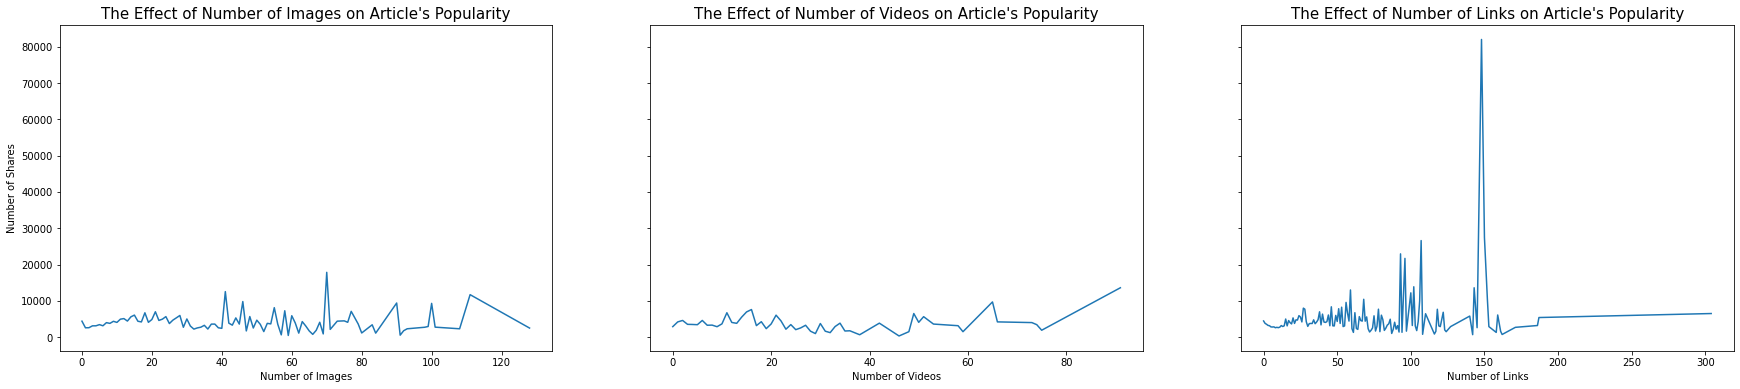

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(30, 6), sharey=True)

sns.lineplot(ax=axes[0], x='num_imgs', y='shares', data=news, ci=None)
axes[0].set_title("The Effect of Number of Images on Article's Popularity", fontsize = 15)
axes[0].set(xlabel='Number of Images', ylabel='Number of Shares')

sns.lineplot(ax=axes[1], x='num_videos', y='shares', data=news, ci=None)
axes[1].set_title("The Effect of Number of Videos on Article's Popularity", fontsize = 15)
axes[1].set(xlabel='Number of Videos', ylabel='Number of Shares')

sns.lineplot(ax=axes[2], x='num_hrefs', y='shares', data=news,ci=None)
axes[2].set_title("The Effect of Number of Links on Article's Popularity", fontsize = 15)
axes[2].set(xlabel='Number of Links', ylabel='Number of Shares')

grid = plt.GridSpec(1, 3, hspace=1, wspace=1)

In [ ]:
# return the articles with links equal or greater than 148
len(news[news.num_hrefs >= 148])

12

In [ ]:
# return the article with 148 links
news[news.num_hrefs == 148]

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
23434            12.0            1364.0      148.0             3.0      14.0   

       num_videos  num_keywords  data_channel_is_lifestyle  \
23434         0.0          10.0                        0.0   

       data_channel_is_entertainment  data_channel_is_bus  ...  \
23434                            0.0                  0.0  ...   

       global_rate_positive_words  global_rate_negative_words  \
23434                    0.027859                    0.030059   

       avg_positive_polarity  avg_negative_polarity  title_subjectivity  \
23434               0.486626              -0.351965                0.35   

       title_sentiment_polarity  shares       date  published_year  \
23434                       0.3   82000 2014-04-13            2014   

       published_month  
23434                4  

[1 rows x 36 columns]

### 4. What is the relationship between number of keywords and number of shares?
In addition to images, videos, etc, containing keywords in the metadata is also important for an article. Based on the bar chart generated below, there is a clear trend between the number of keywords and number of shares. There is almost a steady increase in the number of shares when the number of keywords is from 1 to 5. When the number of keywords exceeds 5, the number of shares is stable. The result implies that including more keywords in an article will lead to a higher number of shares. Nine keywords seem to be the most promising number.

[Text(0, 0.5, 'Number of Shares'), Text(0.5, 0, 'Number of Keywords')]

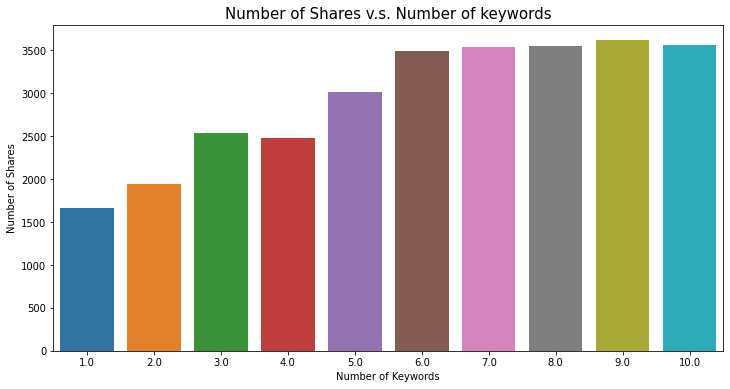

In [ ]:
plt.subplots(1,1,figsize=(12, 6))
plt.subplot(1,1,1)
plt.title('Number of Shares v.s. Number of keywords', fontsize = 15)
ax = sns.barplot(data=news, x='num_keywords', y='shares', ci=False)
ax.set(xlabel='Number of Keywords', ylabel='Number of Shares')

### 5. Does the rate of positive or negative words in the content relate to the popularity of the article? 
The following codes generate a line plot containing two subplots. Based on the graph shown below, the article has more shares when the rate of positive words is between 0.10 to 0.14 and the rate of negative words is between 0.01 to 0.04. The mean of the rate of positive and negative words is around 0.04 and 0.02 respectively. The number of occurrences of positive and negative words in the article can directly affect readers’ sentiment, thus the results indicate that readers enjoy sharing the article when the article has more positive words and a moderate number of negative words. The potential reason is that readers are more likely to share articles which contain more perspectives than articles which lean to one side.

Moreover, in order to have a clear picture of the trend, we round the rate of +ve and -ve words to 3 decimal places. You may notice that there are several spikes in the share of -ve words compared to +ve words. There is a steady increase in shares for a larger -ve words rate. The reason is that there are lots of articles that have a rate of -ve words greater than 0.06 and smaller than 0.105, and several articles within this range have numerous shares, thus causing several spikes. Furthermore, there are only two articles that have a rate of -ve words greater than 0.155, and one of them has 27,900 shares, thus causing the steady increase in shares for a larger -ve word rate.

In [ ]:
# return the mean of the rate of positive and negative words
print('mean of the rate of positive words: ' , round(news['global_rate_positive_words'].mean(),2))
print('mean of the rate of negative words: ', round(news['global_rate_negative_words'].mean(),2))

mean of the rate of positive words:  0.04
mean of the rate of negative words:  0.02


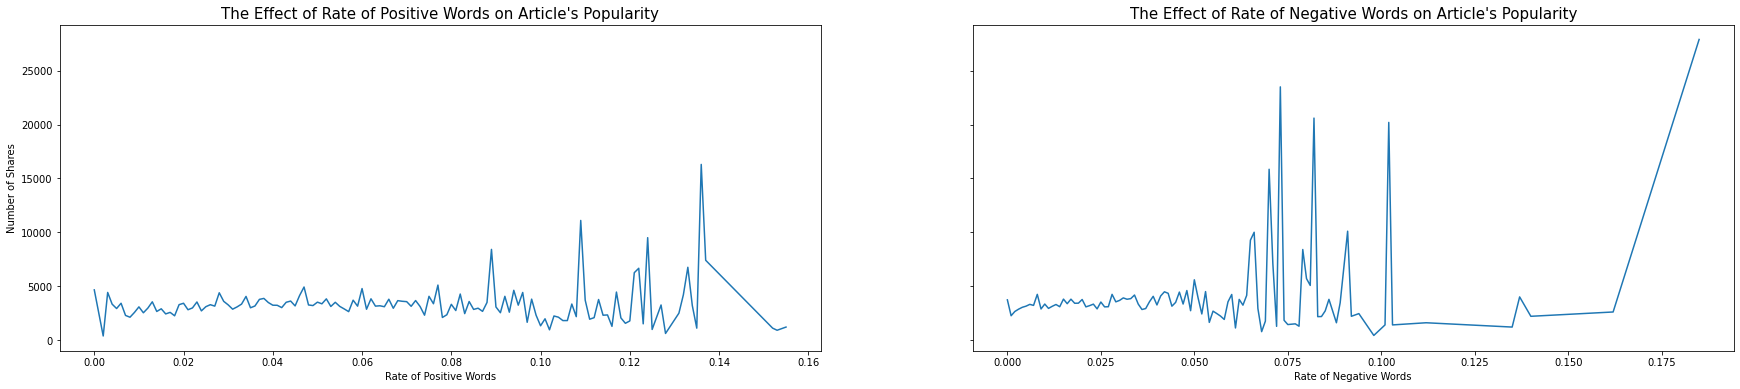

In [ ]:
# return the line plot
fig, axes = plt.subplots(1, 2, figsize=(30, 6), sharey=True)

sns.lineplot(ax=axes[0], x=round(news['global_rate_positive_words'],3), y='shares', data=news, ci=None)
axes[0].set_title("The Effect of Rate of Positive Words on Article's Popularity", fontsize = 15)
axes[0].set(xlabel='Rate of Positive Words', ylabel='Number of Shares')

sns.lineplot(ax=axes[1], x=round(news['global_rate_negative_words'],3), y='shares', data=news, ci=None)
axes[1].set_title("The Effect of Rate of Negative Words on Article's Popularity", fontsize = 15)
axes[1].set(xlabel='Rate of Negative Words', ylabel='Number of Shares')

grid = plt.GridSpec(1, 2, hspace=1, wspace=1)

In [ ]:
# return articles with the rate of negative words equal or greater than 0.155
len(news[news['global_rate_negative_words'] >= 0.155])

2

In [ ]:
# return the article with 0.185 rate of -ve words
news[news['global_rate_negative_words'] >= 0.184]

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
24971             8.0             146.0       26.0             2.0      23.0   

       num_videos  num_keywords  data_channel_is_lifestyle  \
24971         0.0           8.0                        0.0   

       data_channel_is_entertainment  data_channel_is_bus  ...  \
24971                            0.0                  0.0  ...   

       global_rate_positive_words  global_rate_negative_words  \
24971                    0.034247                    0.184932   

       avg_positive_polarity  avg_negative_polarity  title_subjectivity  \
24971                  0.232              -0.403704                 0.0   

       title_sentiment_polarity  shares       date  published_year  \
24971                       0.0   27900 2014-05-09            2014   

       published_month  
24971                5  

[1 rows x 36 columns]

In [ ]:
# return the number of articles which falls into the range of 0.06 to 0.105
len(news[(news['global_rate_negative_words'] >= 0.06) & (news['global_rate_negative_words'] <= 0.105)])

130

In [ ]:
# return the number of articles which falls into the range of 0.06 to 0.105 and has more than 1,0000 shares
len(news[(news.global_rate_negative_words >= 0.06) & (news.global_rate_negative_words <= 0.105) & (news.shares > 10000)])

15

### 6. What is the distribution of shares during a week? 
Based on the graph shown below, people prefer sharing news on weekdays (excluding Friday) than weekends. The number of shares is stable from Monday to Thursday which is around 24 million shares. However, the number of shares decreased by around 4 million shares after Thursday. We assumed that people may have different weekend schedules like parties, shopping, etc, which will decrease the time they spend on reading and sharing news.

In [ ]:
col=[col for col in news if col.startswith('weekday_is')]
total_shares = [news[news[c]==1]['shares'].sum() for c in col]

fig = px.bar(x=col, y=total_shares, title='Distribution of Shares in One Week', 
             labels={'x':'Weekdays','y':'Number of Shares'}, text_auto='.2s',
             width=1000, height=600)
fig.update_layout(title_x=0.5)
fig.show()

### 7. What is the distribution of popular v.s. unpopular news during a week?
As mentioned earlier, the distribution of shares is right skewed, therefore we developed a deeper analysis of shares in one week. We used the median to classify popular and unpopular news since the mean only works under normal distribution. Based on the graph, the popular and unpopular news don’t have a big difference on weekdays (from Monday to Thursday). The reason may be that people focus on their work during the day so they have little time to rest, usually during the lunch break. Thus, people may just glance at their phones in a hurry instead of purposely searching to share what they like or what is popular. From Friday to Sunday, it can be seen that the share of popular news is much higher than the unpopular news. The reason may be because people have more leisure time on weekends and they have more time to choose which article they like and which to share.

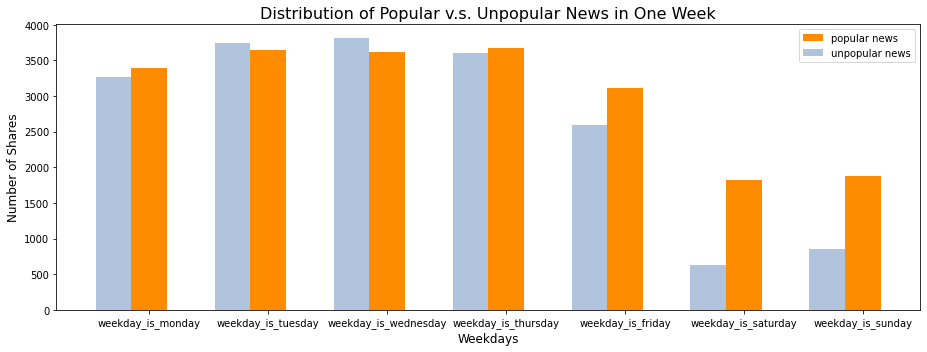

In [ ]:
median_share = news.shares.median()
Days = news.columns.values[16:23]
popular = news[news['shares']>= median_share]
unpopular= news[news['shares'] < median_share]
popular_news = popular[Days].sum().values
unpopular_news = unpopular[Days].sum().values
fig = plt.figure(figsize = (13,5))
plt.title("Distribution of Popular v.s. Unpopular News in One Week", fontsize = 16)
plt.bar(np.arange(len(Days)), popular_news, width = 0.3, align="center", color = 'darkorange', \
          label = "popular news")
plt.bar(np.arange(len(Days)) - 0.3 , unpopular_news, width = 0.3, align = "center", color = 'lightsteelblue', \
          label = "unpopular news")
plt.xticks(np.arange(len(Days)), Days)
plt.ylabel("Number of Shares", fontsize = 12)
plt.xlabel("Weekdays", fontsize = 12)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

### 8. What is the distribution of shares across different channels?
Based on the graph shown below, the channel that has the most shares is Tech, with around 22 million shares. The next three highest channels are Entertainment, World, and Business, all hovering around 20 million shares. The Social Media and Lifestyle channels have the least amount of shares, both below 10 million shares. The top four channels have such a drastic difference in amount of shares with both Social Media and Lifestyle most likely because the former generate articles that stimulate more discussion and fit more into people’s daily conversations, while the latter attracts a niche audience.

In [ ]:
col_channels=[col for col in news if col.startswith('data_channel')]
total_shares_channels = [news[news[c]==1]['shares'].sum() for c in col_channels]

fig = px.bar(x=col_channels, y=total_shares_channels, 
             title='Distribution of Shares across Channels',
             labels={'x':'Channels','y':'Number of Shares'}, text_auto='.2s',
             width=1000, height=600)
fig.update_layout(title_x=0.5)
fig.show()

### 9. What is the distribution of popular v.s. unpopular news across different channels?
According to the graph, the shares of unpopular news in the Entertainment and World channels are higher than the shares of popular news. Lifestyle, Business, Social Media, and Technology channels indicate that the shares of popular news are higher than the shares of unpopular news. Among those channels, Technology has the highest shares of popular news. The reason may be because of the sample of the dataset. In other words, we don’t know the demographic variables of the dataset, such as gender, age, job, etc, which will cause different results. For example, if more people of this dataset work in technology, then it’s more likely for them to engage with articles related to technology instead of entertainment.

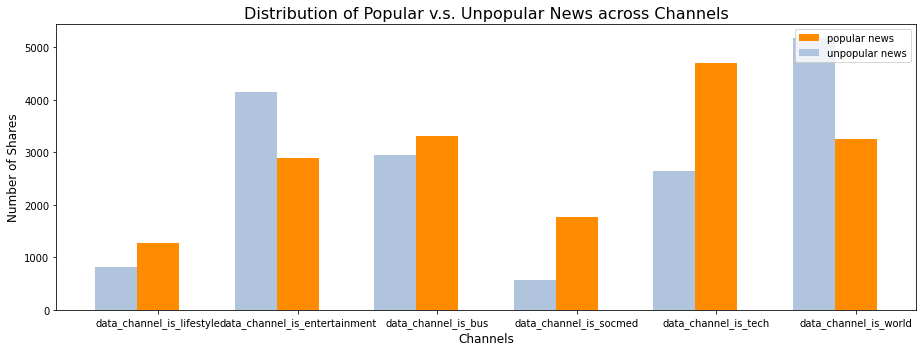

In [ ]:
median_share = news.shares.median()
Channels = news.columns.values[7:13]
popular = news[news['shares']>= median_share]
unpopular= news[news['shares'] < median_share]
popular_news = popular[Channels].sum().values
unpopular_news = unpopular[Channels].sum().values
fig = plt.figure(figsize = (13,5))
plt.title("Distribution of Popular v.s. Unpopular News across Channels", fontsize = 16)
plt.bar(np.arange(len(Channels)), popular_news, width = 0.3, align="center", color = 'darkorange', \
          label = "popular news")
plt.bar(np.arange(len(Channels)) - 0.3 , unpopular_news, width = 0.3, align = "center", color = 'lightsteelblue', \
          label = "unpopular news")
plt.xticks(np.arange(len(Channels)), Channels)
plt.ylabel("Number of Shares", fontsize = 12)
plt.xlabel("Channels", fontsize = 12)
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

### 10. How do the number of shares vary overtime in 2013 and 2014?
We generated a time series graph in order to see how the number of shares vary in 2013 and 2014. According to the graph, there are some spikes in different months in each year. After we dug into the dataset, we found out that there are several articles that have huge shares causing the spike in their corresponding month. For instance, in March 2013, the article “[Viral Video Shows the Extent of U.S. Wealth Inequality](https://mashable.com/archive/wealth-inequality)” has 617,900 shares; in July 2013, the article “[The Leaks of the New iPhone model](https://mashable.com/archive/low-cost-iphone)” goes viral and has 843,300 shares which is the highest shares in 2013 and 2014; in November 2013, the article “[Kanye West Lectures at Harvard](https://mashable.com/archive/kanye-west-harvard-lecture)” has 652,900 shares; in January 2014, the article “[Australia's temperature reaching 117F](https://mashable.com/archive/australia-heatwave-photos)” has 310,800 shares. These articles with large shares cause the variability shown in the graph. The average shares of Mashable articles in each month fall between the range of 2,500 to 5,000 which is a satisfying number.

Text(0.5, 1.0, 'Change of Shares in 2013 & 2014')

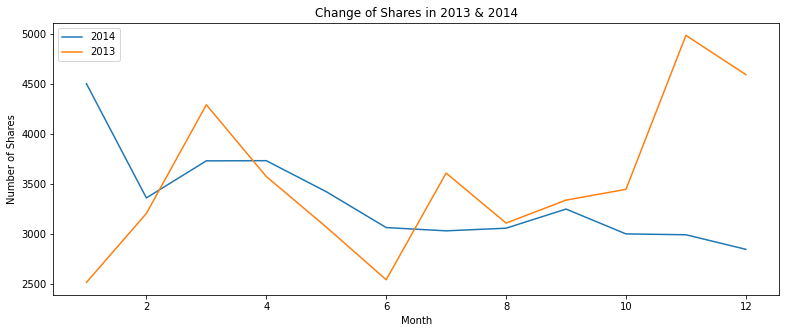

In [ ]:
plt.figure(figsize=(13,5)) 
news2013=news[news['published_year']==2013]
news2014=news[news['published_year']==2014]
news2014.groupby('published_month')['shares'].mean().plot(legend=True,label='2014')
news2013.groupby('published_month')['shares'].mean().plot(legend=True,label='2013')
plt.xlabel('Month')
plt.ylabel('Number of Shares')
plt.title('Change of Shares in 2013 & 2014')

## **Part 7: Classification Prediction Model**


### 1. Target Variable
Since `shares` is right-skewed, we adjusted the distribution by applying log transformation to `shares` in order to avoid imbalance in our target variable. After the transformation, the distribution of `shares` appears to resemble a normal distribution. To create our target variable for our classification model,  we use the average number of shares as a threshold and transform shares into a binary column called `popular`. 
After the transformation, the distribution of ‘shares’ appears to resemble a normal distribution. In addition, the percentage of unpopular news is 59% and popular news is 41% which is a little imbalance.

In [ ]:
# create a copy of the dataset
news1=news.copy()

# log transform the target variable
news1['shares']=np.log(news1['shares'])

# transfer `shares` to `popular`
news1['shares']=[1 if i > news1['shares'].mean() else 0 for i in news1['shares']]
news1 = news1.rename(columns = {'shares':'popular'})

# drop `date` column
news1=news1.drop('date',axis=1)

# check the dataset
news1.head(3)

n_tokens_title  n_tokens_content  num_hrefs  num_self_hrefs  num_imgs  \
0            12.0             219.0        4.0             2.0       1.0   
1             9.0             255.0        3.0             1.0       1.0   
2             9.0             211.0        3.0             1.0       1.0   

   num_videos  num_keywords  data_channel_is_lifestyle  \
0         0.0           5.0                        0.0   
1         0.0           4.0                        0.0   
2         0.0           6.0                        0.0   

   data_channel_is_entertainment  data_channel_is_bus  ...  \
0                            1.0                  0.0  ...   
1                            0.0                  1.0  ...   
2                            0.0                  1.0  ...   

   global_sentiment_polarity  global_rate_positive_words  \
0                   0.092562                    0.045662   
1                   0.148948                    0.043137   
2                   0.323333                    0.056872   

   global_rate_negative_words  avg_positive_polarity  avg_negative_polarity  \
0                    0.013699               0.378636              -0.350000   
1                    0.015686               0.286915              -0.118750   
2                    0.009479               0.495833              -0.466667   

   title_subjectivity  title_sentiment_polarity  popular  published_year  \
0                 0.5                   -0.1875        0            2013   
1                 0.0                    0.0000        0            2013   
2                 0.0                    0.0000        0            2013   

   published_month  
0                1  
1                1  
2                1  

[3 rows x 35 columns]

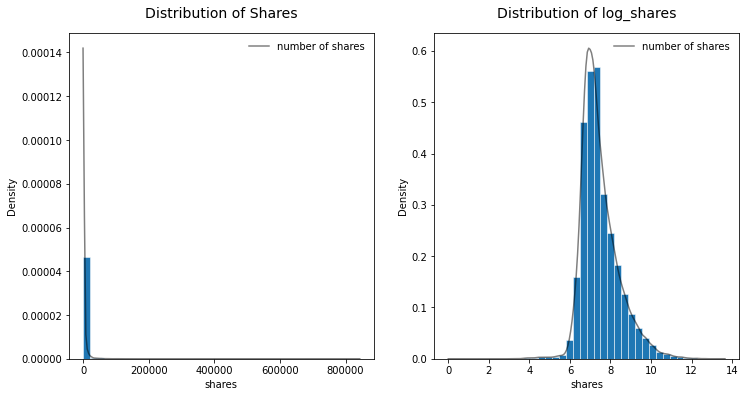

In [ ]:
# plot the histogram of shares
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
ax = sns.histplot(data=news['shares'], bins=40, stat='density', alpha= 1, kde=True,
                  edgecolor='white', linewidth=0.5,
                  line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='number of shares'))
ax.get_lines()[0].set_color('black') 

ax.legend(frameon=False)
ax.set_title('Distribution of Shares', fontsize=14, pad=15)
plt.subplot(1, 2, 2)
ax2 = sns.histplot(data=np.log(news['shares']), bins=40, stat='density', alpha= 1, kde=True,
                  edgecolor='white', linewidth=0.5,
                  line_kws=dict(color='black', alpha=0.5, linewidth=1.5, label='number of shares'))
ax2.get_lines()[0].set_color('black') 

ax2.legend(frameon=False)
ax2.set_title('Distribution of log_shares', fontsize=14, pad=15)

plt.show()

In [ ]:
# examine target variable
pd.DataFrame({'popular':[0,1],'percentage': round(news1.popular.value_counts()*100/len(news1),2)})

popular  percentage
0        0       59.42
1        1       40.58

### 2. Random Forest Classification
We chose Random Forest as it is great for classification problems and has many additional built-in features that adds randomness to the model with sets of decision trees. We splitted the data with a 75:25 split and constructed a pipeline to transform our numerical and categorical features.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
set_config(display='diagram')

# split data with a 75:25 split
train, test = train_test_split(news1, test_size = .25, random_state=11)
print(train.shape, test.shape)

# subset target variable and features
df_X=train.drop('popular',axis=1)
df_y=train['popular']
 
# prepare categorical and numerical features for pipeline
drop = [i for i in df_X if i.startswith(('is','weekday','data_channel','published'))]
num_cols=df_X.drop(drop,axis=1).columns
cat_cols=df_X[drop].columns

# preprocess numerical features with log transformation to deal with right-skewed features 
num_pipe = Pipeline([
    ('imputer', SimpleImputer()),
    ('StandardScaler',StandardScaler())
])

cat_pipe = Pipeline([
    ('imputer',SimpleImputer())
])

preprocessor = ColumnTransformer([
    ('numerical',num_pipe,num_cols),
    ('categorical',cat_pipe,cat_cols)
])
preprocessor

# train Model
X = preprocessor.fit_transform(df_X)
y = df_y.values
rcf=RandomForestClassifier(random_state=42,n_estimators=500,max_depth=5,n_jobs=4)
rcf.fit(X,y)

(29733, 35) (9911, 35)


RandomForestClassifier(max_depth=5, n_estimators=500, n_jobs=4, random_state=42)

### 3. Feature Importance
In order to get some features which are good predictors for popularity, we used the Random Forest classifier to compute the feature importance. Since the information of variables we dropped at the beginning is insufficient, we excluded those variables here. Based on the output, `data_channel_is_lifestyle`, `data_channel_is_bus`, and `is_weekend` are good predictors for articles’ popularity, especially `data_channel_is_lifestyle`. In addition, `data_channel_is_bus` and `is_weekend` are the next two important features which suggest that articles published during weekends or located at the Business channel tend to be more popular. On the other hand, a lot of numerical features, such as `global_rate_positive_words`, `global_subjective`, and `global_sentiment_polarity`, are not important features to predict the popularity.


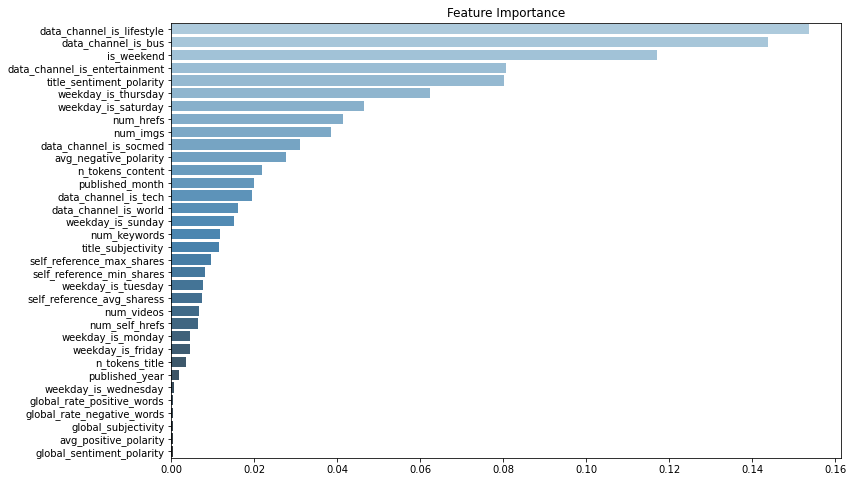

In [ ]:
imp = pd.Series(data=rcf.feature_importances_, index=df_X.columns).sort_values(ascending=False)
plt.figure(figsize=(12,8))
plt.title("Feature Importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

### 4. Model Evaluation
Based on the ROC curve, the number of both class 0 and 1 are 0.68 which means that the model has a fair performance of our dataset but not the best. For the micro and macro average score, they calculated slightly different things. A macro-average will compute the metric independently for each class and then take the average with treating all classes equally, whereas a micro-average will aggregate the contributions of all classes to compute the average metric. We prefer micro numbers here because there will be one more example of each classifier. A micro-average score of 0.7 also shows that the whole model works fine for our dataset. 


In [ ]:
# compute the metric scores
from sklearn.metrics import accuracy_score, balanced_accuracy_score,confusion_matrix
X_test= preprocessor.transform(test)
y_test = test['popular']
y_pred = rcf.predict(X_test)
print("The accuracy score is {}".format(accuracy_score(y_test, y_pred).round(4)))
print("The balanced accuracy score is {}".format(balanced_accuracy_score(y_test, y_pred).round(4)))

The accuracy score is 0.6501
The balanced accuracy score is 0.5902


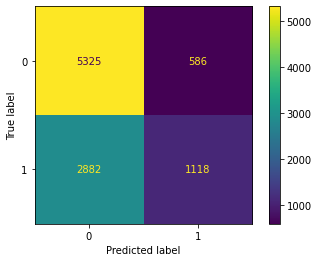

In [ ]:
# return the cofusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
# return the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.90      0.75      5911
           1       0.66      0.28      0.39      4000

    accuracy                           0.65      9911
   macro avg       0.65      0.59      0.57      9911
weighted avg       0.65      0.65      0.61      9911



In [ ]:
pip install scikit.plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



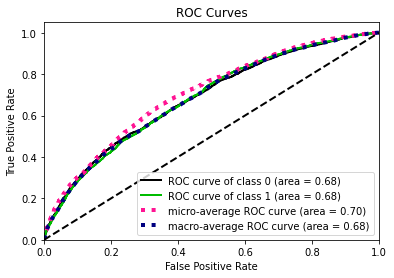

In [ ]:
# compute the ROC curve
import scikitplot as skplt
import matplotlib.pyplot as plt
y_true = np.array(y_test)
y_probas = rcf.predict_proba(X_test)
np.concatenate((1-y_probas,y_probas))
skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

## **Part 8: Conclusion**
By conducting our analysis, we were able to explore what attributes of online articles will lead to a higher number of shares of the articles. We used the number of shares as a key indicator of an article's popularity and discovered several key characteristics of online news that will lead to higher popularity. Some insights that we gained from our analysis are that readers are more likely to share articles with moderate amounts of images, more videos, links, keywords, and positive words, and a moderate number of negative words. Besides, there are more shares during weekdays and in specific channels such as Tech. Finally, based on the classification prediction model, the AUC score is 0.68. The performance of our model was fair but wasn’t great. With a more implemented prediction model, we believe our analysis can help web media companies increase website traffic and gain more readers.

## **Part 9: References**
1. https://core.ac.uk/download/pdf/55638607.pdf
2. https://pythonguides.com/matplotlib-multiple-bar-chart/
3. http://www.youtube.com/watch?v=SjrphzGCess
4. https://stackoverflow.com/questions/12453580/how-to-concatenate-join-items-in-a-list-to-a-single-string
5. https://mashable.com/archive/beyonce-coachella-solance-video
6. https://github.com/soltaniehha/Intro-to-Data-Analytics/blob/main/09-EDA/01-Exploratory-Data-Analysis.ipynb
7. https://mashable.com/archive/wealth-inequality
8. https://mashable.com/archive/low-cost-iphone
9. https://mashable.com/archive/kanye-west-harvard-lecture
10. https://mashable.com/archive/australia-heatwave-photos







